In [1]:
# AdComp Final Exam: Monte Carlo Simulation of Intermolecular Forces
# The following code was developed in 90 minutes by Evan Shelton, with assistance on chemical theory from Dr. George Thurston
# RIT College of Science, 4/24/2023

# Import packages
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as constants
import random

# Define constants
e0 = constants.epsilon_0 # Farads/m, we want Farads/Angstrom.
e0 *= 1e10 # convert e0 to Farads/Angstrom
er = 78.5 # Angstroms
k_b = constants.Boltzmann
k_b *= 6.2415E+18 # convert k_b to ev/K
kappa = 1/8.8 # Angstroms^-1
e_charge = constants.e

# The pK value for arginine (which primarily makes up protamine) is about 12.48 according to reference paper.
pK = 12.48

In [2]:
###### This section holds adjustable parameters for the 2-site code block below. Do not alter anything outside of this block. ######

# How many significant figures should we tell numpy to round to in the printed results?
## Default: 4
sigfigs = 4

# How long should each pH simulation be simulated, in seconds? Higher values will be more accurate thanks to the law of large numbers,
# but will also take longer to simulate. If the simulation is taking too long, lower this first!
## Default: 5 minutes
timeLimit = 5*60.

# Should the results of the simulation be printed directly to the output below the cell?
## Default: True
printResults = True

# Should the results of the simulation be plotted directly below the cell, with a comparison to the Henderson-Hasselbalch equation?
## Default: True
plotResults = True

# Which pH values should this program simulate? Note that more pH values will require more computational power; if running a large
# number of pH values, consider lowering timeLimit up above! Additionally, alternative methods for this list such as np.linspace or
# np.arange will work perfectly fine as well.
## Default: [pK, 10, 11, 12, 13, 14]
pHList = [pK, 10, 11, 12, 13, 14]

# K_off can also be changed here, to simulate non-arginine based sites; the default of 600 (s^-1) corresponds to arginine.
## Default: 600
k_off = 600

###### This section holds adjustable parameters for the 2-site code block below. Do not alter anything outside of this block. ######

## A note on the possible macrostates/microstates
Given a 2-atom system, there are only FOUR (2^n) possible microstates: \
ON/ON\
ON/OFF\
OFF/ON\
OFF/OFF\
\
Additionally, these states cannot be freely switched between; for example, it would take two steps, not one, to move from ON/ON to OFF/OFF. The best way to visualize these states and the way to move between them is to imagine a 'diamond' microstate map (pictured below.)

$\text{K}_{\text{off}}$ is (largely) independent from the pH of the solution, whereas $\text{K}_{\text{on}}$ is not; thus, $\text{K}_{\text{off}}$ can be considered a constant, while $\text{K}_{\text{on}}$ must be redetermined with every shift in pH.

<center><img src="DiamondDiagram.png" style="height: 400px;"/></center>

pH = 12.48
Time Simulated: 300.002 seconds. Total State Changes: 359060
Time Spent in On/On Microstate: 75.067 seconds, 25.0222 % of total time.
Henderson-Hasselbalch Prediction: 25.0 % of total time.
Time Spent in On/Off Microstate: 75.1896 seconds, 25.0631 % of total time.
Henderson-Hasselbalch Prediction: 25.0 % of total time.
Time Spent in Off/On Microstate: 75.0664 seconds, 25.022 % of total time.
Henderson-Hasselbalch Prediction: 25.0 % of total time.
Time Spent in Off/Off Microstate: 74.6787 seconds, 24.8928 % of total time.
Henderson-Hasselbalch Prediction: 25.0 % of total time.

pH = 10
Time Simulated: 300.0 seconds. Total State Changes: 717589
Time Spent in On/On Microstate: 298.0225 seconds, 99.3408 % of total time.
Henderson-Hasselbalch Prediction: 99.341 % of total time.
Time Spent in On/Off Microstate: 0.9869 seconds, 0.329 % of total time.
Henderson-Hasselbalch Prediction: 0.3289 % of total time.
Time Spent in Off/On Microstate: 0.9874 seconds, 0.3291 % of total time.
He

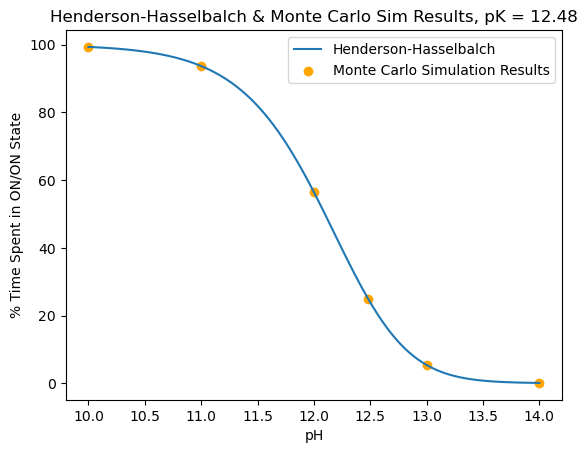

In [3]:
# This function uses the kappa value (rate) alongside the RNG to determine the time until the next state change. See Schroeder for more info!
def findTime(randomNumber, k):
    return -np.log(1-randomNumber) / k

# Standard Henderson-Hasselbalch equation, rearranged for our purposes within this program.
def HH(pH, pK):
    return (1 + 10**(pH-pK))**-1
# Note the significance of pH = 12.48, in which pH = pK for arginine. At this pH, Henderson-Hasselbalch predicts a
# symmetrical probability distribution - each state should be present for 25% of the total time.

# Initialize array used within the for loop to generate the HH vs Monte Carlo plot right below it.
timeInOnOnState = np.array([], dtype = float)

for pH in pHList:
    # k_on is related to both k_off and the pK/pH difference.
    k_on = k_off * 10**(pK - pH)
    # timeElapsed controls the total amount of time in seconds that the system has simulated. Always start this at zero seconds elapsed.
    timeElapsed = 0.
    
    # timeInState holds the amount of time that each microstate stays active.
    # Since this is similar to the standard coinflip microstates scenario, the total number of microstates is simply 2^n.
    # At the end of the simulation, this can be used to determine probability distributions.
    timeInState = np.zeros([4])

    # State Array holds the On/Off state of each site. We start in the microstate in which all sites are 'On'.
    stateArray = np.full([2], True, dtype = bool)

    # Time Until holds the values for the simulated times until the next state change occurs.
    timeUntil = np.zeros([2])

    # This iterations variable is just to tell us the total number of state flips we underwent!
    iterations = 0

    while timeElapsed < timeLimit:
        iterations += 1

        # Iterate through every site to find a length of time until that state is simulated to flip.
        for site in range(len(stateArray)):
            # If this particular site is already 'On', we need to use K_off to figure out the time until it pops off.
            if stateArray[site]:
                timeUntil[site] = findTime(random.random(), k_off)
            # This elif condition is satisfied if the current site is 'Off'.
            elif not stateArray[site]:
                timeUntil[site] = findTime(random.random(), k_on)
            # This is a failsafe else condition, in case something unexpectedly goes wrong.
            else:
                print('Error: stateArray[site] not boolean.')

        # Once we know which state is simulated to switch in the shortest period of time, let's record this 'waiting time' as time spent in the current state.
        if stateArray[0] == True and stateArray[1] == True:
            # We are in microstate #1: On/On.
            timeInState[0] += np.min(timeUntil)
        elif stateArray[0] == True and stateArray[1] == False:
            # We are in microstate #2: On/Off.
            timeInState[1] += np.min(timeUntil)
        elif stateArray[0] == False and stateArray[1] == True:
            # We are in microstate #3: Off/On.
            timeInState[2] += np.min(timeUntil)
        elif stateArray[0] == False and stateArray[1] == False:
            # We are in microstate #4: Off/Off.
            timeInState[3] += np.min(timeUntil)
        else:
            # This is a failsafe else condition, in case something unexpectedly goes wrong.
            print('Error: Ambiguous microstate.')

        # Advance elapsedTime by the minimum state change amount.
        timeElapsed += np.min(timeUntil)
        # Go ahead and flip that state to the opposite boolean value as well.
        stateArray[np.argmin(timeUntil)] = not stateArray[np.argmin(timeUntil)]

    if printResults:
        print('pH =', pH)
        print('Time Simulated:', np.round(timeElapsed, 3), 'seconds. Total State Changes:', iterations)
        
        # Microstate: ON/ON
        print('Time Spent in On/On Microstate:', np.round(timeInState[0], sigfigs), 'seconds,', np.round(timeInState[0]/ timeElapsed *100, sigfigs), '% of total time.')
        print('Henderson-Hasselbalch Prediction:', np.round(HH(pH, pK)**2 * 100, sigfigs), '% of total time.')
        
        # Microstate: ON/OFF
        print('Time Spent in On/Off Microstate:', np.round(timeInState[1], sigfigs), 'seconds,', np.round(timeInState[1]/ timeElapsed *100, sigfigs), '% of total time.')
        print('Henderson-Hasselbalch Prediction:', np.round((HH(pH, pK) * (1 - HH(pH, pK))) * 100, sigfigs), '% of total time.')
        
        # Microstate: OFF/ON
        print('Time Spent in Off/On Microstate:', np.round(timeInState[2], sigfigs), 'seconds,', np.round(timeInState[2]/ timeElapsed *100, sigfigs), '% of total time.')
        print('Henderson-Hasselbalch Prediction:', np.round((HH(pH, pK) * (1 - HH(pH, pK))) * 100, sigfigs), '% of total time.')
        
        # Microstate: OFF/OFF
        print('Time Spent in Off/Off Microstate:', np.round(timeInState[3], sigfigs), 'seconds,', np.round(timeInState[3]/ timeElapsed *100, sigfigs), '% of total time.')
        print('Henderson-Hasselbalch Prediction:', np.round((1 - HH(pH, pK))**2 * 100, sigfigs), '% of total time.\n')
    
    if plotResults:
        # Save the amount of time spent in ON/ON microstate, for use in plotting right below this loop.
        timeInOnOnState = np.append(timeInOnOnState, timeInState[0])

if plotResults:
    # Let's go ahead and generate a plot of the relative time spent in the ON/ON state versus the HH prediction.
    pHDomain = np.linspace(np.min(pHList), np.max(pHList[-1]), 101)
    # Open a new figure. Only necessary if additional plots are made above, but added just in case.
    plt.figure()
    # Plot the Henderson-Hasselbalch relationship over pHDomain
    plt.plot(pHDomain, 100 * HH(pHDomain, pK)**2, label = 'Henderson-Hasselbalch')
    # Plot the result of our Monte Carlo Simulation: Time spent in On/On State
    plt.scatter(pHList, 100 * timeInOnOnState / timeLimit, label = 'Monte Carlo Simulation Results', color = 'orange')
    # Clean up, add labels and legend, etc
    plt.xlabel('pH')
    plt.ylabel('% Time Spent in ON/ON State')
    plt.legend()
    plt.title('Henderson-Hasselbalch & Monte Carlo Sim Results, pK = ' + str(pK))

## Next step: Simulating intermolecular attraction based on distance between active sites
In the Henderson-Hasselbalch assumption, the individual sites are treated as not affecting each other - this is an idealistic approach that does not accurately describe the behavior of very complex systems with tightly-packed sites, as is the case with the protamines we are trying to analyze. However, sites without a proton (those in the 'off' state) are treated by adjacent sites as having a charge of approximately zero. That means that for our two-site system developed above, the only case in which we expect a departure from the Henderson-Hasselbalch behavior is the ON/ON microstate, in which the two protons are repelling each other, coaxing themselves out of their current location. This makes the ON/ON microstate more fleeting, and less likely to maintain an extended duration. This will affect its relative time distribution outlined above, which will of course affect the time spent in the three other microstates (though the three non-altered states will maintain the same probability relative to each other.)

This simulation is begun in the following code block, but was unable to be completed within the 90-minute final exam timeframe.

In [4]:
# Import data from text file
unused1, sNumber, atomType, amino, unused2, bNumber, xPos, yPos, zPos, scale, charge, unused3 = np.loadtxt('AtlanticSalmonProtamine.txt', unpack = True, dtype = str)

a = 12
# arange excludes the final value. To include 19, b needs to be 20.
b = 13
# Number of sites is b - a, but inclusive, so we need to add 1.
n = b - a + 1

distArray = np.zeros([n, n])

# Filter out only the lines of the .pdb file which correspond to NH1 atoms.
NH1sNumbers = sNumber[np.where(atomType == "NH1")]

# This line, when uncommented, displays the ID numbers of ALL NH1 atoms.
#print(NH1sNumbers)

# We want to isolate NH1 atoms a through b
NH1sNumbers = sNumber[np.where(atomType == "NH1")][a:b+1]
print('Text file ID numbers for the 12th and 13th NH1 atoms are:\n', NH1sNumbers, '\n')



for i in range(0, len(NH1sNumbers)):
    # The 'host' is the atom i that we are currently iterating through.
    hostPos = float(xPos[np.where(sNumber == NH1sNumbers[i])]), \
    float(yPos[np.where(sNumber == NH1sNumbers[i])]), \
    float(zPos[np.where(sNumber == NH1sNumbers[i])])
    
    print('Atom', NH1sNumbers[i], 'is located at', np.round(hostPos, 2))
    
    for target in range(0, len(NH1sNumbers)):
        # The 'target' is each of the other atoms that the host's distance needs to be determined for.
        if i != target: # Check to make sure the host and target particle aren't the same one.
            targetPos = float(xPos[np.where(sNumber == NH1sNumbers[target])]), float(yPos[np.where(sNumber == NH1sNumbers[target])]), \
            float(zPos[np.where(sNumber == NH1sNumbers[target])])
            # Use standard distance equation in cartesian coordinates to find distance between every pair.
            distArray[i][target] = np.sqrt( (targetPos[0] - hostPos[0])**2 + (targetPos[1] - hostPos[1])**2 + (targetPos[2] - hostPos[2])**2 )
        # If the host and target are the same, set distance to zero; this is technically not necessary, but could avoid weird rounding errors.
        else:
            distArray[i][target] = 0.

print('\nThe \'distance table\' between each point combination is\n', np.round(distArray, 3))

Text file ID numbers for the 12th and 13th NH1 atoms are:
 ['201' '212'] 

Atom 201 is located at [-54.83 -13.58  73.36]
Atom 212 is located at [-52.83   0.72  71.14]

The 'distance table' between each point combination is
 [[ 0.    14.618]
 [14.618  0.   ]]
